In [1]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

import pyspark.sql.functions as f

from itertools import chain
import pandas as pd
import numpy as np
import seaborn as sn 
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
DB_USER = 'root'
DB_PASS = 'root'
DB_NAME = 'telco_churn'
HOST = 'localhost:3306'

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

# Import Data

In [5]:
status_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "status",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [6]:
status_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- Churn Value: integer (nullable = true)
 |-- Churn Score: integer (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)



In [7]:
demographic_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "demographics",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [8]:
demographic_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Under 30: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Number of Dependents: integer (nullable = true)



In [9]:
service_df = spark.read.format("jdbc").options(
    url=f"jdbc:mysql://{HOST}/{DB_NAME}",
    driver = "com.mysql.jdbc.Driver",
    dbtable = "services",
    user=DB_USER,
    password=DB_PASS, 
    useSSL=False).load()


In [10]:
service_df.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Referred a Friend: string (nullable = true)
 |-- Number of Referrals: integer (nullable = true)
 |-- Tenure in Months: integer (nullable = true)
 |-- Offer: string (nullable = true)
 |-- Phone Service: string (nullable = true)
 |-- Avg Monthly Long Distance Charges: double (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Service: string (nullable = true)
 |-- Internet Type: string (nullable = true)
 |-- Avg Monthly GB Download: integer (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection Plan: string (nullable = true)
 |-- Premium Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Streaming Music: string (nullable = true)
 |-- Unlimited Data: string (nullable = true)


In [11]:
df = status_df.join(demographic_df, "Customer ID").join(service_df, "Customer ID")

In [12]:
df = df.filter(df['Under 30'] == 'Yes')

In [13]:
print(f"Number of columns: {len(df.columns)}")
df.printSchema()

Number of columns: 48
root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- Churn Value: integer (nullable = true)
 |-- Churn Score: integer (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Under 30: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Number of Dependents: integer (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Referred a Friend: string (nullable = true)
 |-- Number of Referrals: integer (null

# Data Exploration

In [14]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

21/12/04 20:24:00 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4
Customer ID,0953-LGOVU,1450-SKCVI,3195-TQDZX,7244-KXYZN,0516-UXRMT
Count,1,1,1,1,1
Quarter,Q3,Q3,Q3,Q3,Q3
Satisfaction Score,4,3,5,4,3
Customer Status,Stayed,Churned,Joined,Stayed,Stayed
Churn Label,No,Yes,No,No,No
Churn Value,0,1,0,0,0
Churn Score,75,72,42,20,71
CLTV,2562,5276,4050,4690,5801
Churn Category,None,Attitude,None,None,None


In [15]:
# remove duplicate columns
df_cols = df.columns
existed = []
duplicate_col_index = []
idx = 0
for c in df_cols:
    if c in existed:
        duplicate_col_index.append(idx)
    else:
        existed.append(c)
    idx = idx + 1

for i in duplicate_col_index:
    df_cols[i] = df_cols[i] + '_duplicated'
    
df = df.toDF(*df_cols)
cols_to_remove = [c for c in df_cols if '_duplicated' in c]
df = df.drop(*cols_to_remove)

print(duplicate_col_index)

print([df_cols[i] for i in duplicate_col_index])

[11, 19, 20]
['Count_duplicated', 'Count_duplicated', 'Quarter_duplicated']


In [16]:
print(f"Number of columns: {len(df.columns)}")
df.printSchema()

Number of columns: 45
root
 |-- Customer ID: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Quarter: string (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Customer Status: string (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- Churn Value: integer (nullable = true)
 |-- Churn Score: integer (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Churn Category: string (nullable = true)
 |-- Churn Reason: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Under 30: string (nullable = true)
 |-- Senior Citizen: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Number of Dependents: integer (nullable = true)
 |-- Referred a Friend: string (nullable = true)
 |-- Number of Referrals: integer (nullable = true)
 |-- Tenure in Months: integer (nullable = true)
 |-- Offer: string (nullable = true)
 |-- Phone Servi

In [17]:
to_drop = [  # Drop columns not used in the model training
    'Customer ID',
    'Quarter',
    'Customer Status',
    'Churn Value',
    'Churn Score',
    'Churn Category',
    'Churn Reason',
    'Age',
    'Number of Dependents',
    'Referred a Friend',
    'Number of Referrals',
    'Phone Service',
    'Internet Service',
    'Streaming Music',
    'Total Charges',
    'Total Refunds',
    'Total Extra Data Charges',
    'Total Long Distance Charges',
    'Total Revenue'
]

df = df.drop(*to_drop)

df = df.drop(*['Under 30', 'Senior Citizen'])

In [18]:
print(f"Number of columns: {len(df.columns)}")
df.printSchema()

Number of columns: 24
root
 |-- Count: integer (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Tenure in Months: integer (nullable = true)
 |-- Offer: string (nullable = true)
 |-- Avg Monthly Long Distance Charges: double (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Type: string (nullable = true)
 |-- Avg Monthly GB Download: integer (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection Plan: string (nullable = true)
 |-- Premium Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Unlimited Data: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- Paperl

In [19]:
# Check missing values
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
pd.DataFrame(data_agg.take(5), columns=data_agg.columns).transpose()

,0
Count,0
Satisfaction Score,0
Churn Label,0
CLTV,0
Gender,0
Married,0
Dependents,0
Tenure in Months,0
Offer,0
Avg Monthly Long Distance Charges,0


In [20]:
label_col = 'Churn Label'
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
categorical_features = [t[0] for t in df.dtypes if t[1] != 'int' and t[1] != 'double' and t[0] != label_col]
print(f"Total {len(numeric_features)} of numeric features")
print(numeric_features)
print(f"Total {len(categorical_features)} of categorical features")
print(categorical_features)

Total 7 of numeric features
['Count', 'Satisfaction Score', 'CLTV', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge']
Total 16 of categorical features
['Gender', 'Married', 'Dependents', 'Offer', 'Multiple Lines', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method']


In [21]:
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Count,1401,1.0,0.0,1,1
Satisfaction Score,1401,3.346181299072091,1.1738526525779596,1,5
CLTV,1401,4380.441827266239,1151.3834465884077,2003,6499
Tenure in Months,1401,32.371163454675234,24.764505056972883,1,72
Avg Monthly Long Distance Charges,1401,23.24911491791578,15.58062966595056,0.0,49.96
Avg Monthly GB Download,1401,41.92790863668808,27.403541465244256,0,85
Monthly Charge,1401,62.076837972876525,30.526478680602843,18.75,118.6


In [22]:
for col in categorical_features:
    print(df.groupBy(col).count().orderBy('count', ascending=False).toPandas())
    print("\n")
    
print(df.groupBy(label_col).count().orderBy('count', ascending=False).toPandas())
print("\n")

   Gender  count
0    Male    703
1  Female    698


  Married  count
0      No    703
1     Yes    698


  Dependents  count
0         No   1028
1        Yes    373


     Offer  count
0     None    752
1  Offer B    162
2  Offer E    160
3  Offer D    121
4  Offer A    120
5  Offer C     86


  Multiple Lines  count
0             No    859
1            Yes    542


  Internet Type  count
0   Fiber Optic    515
1           DSL    358
2          None    345
3         Cable    183


  Online Security  count
0              No    959
1             Yes    442


  Online Backup  count
0            No    911
1           Yes    490


  Device Protection Plan  count
0                     No    914
1                    Yes    487


  Premium Tech Support  count
0                   No    967
1                  Yes    434


  Streaming TV  count
0           No    885
1          Yes    516


  Streaming Movies  count
0               No    871
1              Yes    530


  Unlimited Data  count
0  

# Data Preprocessing

In [23]:
stages = []

for categoricalCol in categorical_features:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + ' Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + " OHE"])
    stages += [stringIndexer, encoder]

label_string_idx = StringIndexer(inputCol = label_col, outputCol = 'label')
stages.append(label_string_idx)

assemblerInputs = [c + " OHE" for c in categorical_features] + numeric_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages.append(assembler)
print(f"Number of stages: {len(stages)}")

Number of stages: 34


In [24]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
preprocessed_df = pipelineModel.transform(df)
preprocessed_df.printSchema()

root
 |-- Count: integer (nullable = true)
 |-- Satisfaction Score: integer (nullable = true)
 |-- Churn Label: string (nullable = true)
 |-- CLTV: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Tenure in Months: integer (nullable = true)
 |-- Offer: string (nullable = true)
 |-- Avg Monthly Long Distance Charges: double (nullable = true)
 |-- Multiple Lines: string (nullable = true)
 |-- Internet Type: string (nullable = true)
 |-- Avg Monthly GB Download: integer (nullable = true)
 |-- Online Security: string (nullable = true)
 |-- Online Backup: string (nullable = true)
 |-- Device Protection Plan: string (nullable = true)
 |-- Premium Tech Support: string (nullable = true)
 |-- Streaming TV: string (nullable = true)
 |-- Streaming Movies: string (nullable = true)
 |-- Unlimited Data: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- Paperless Billing: string (n

In [25]:
pd.DataFrame(preprocessed_df.take(5), columns=preprocessed_df.columns).transpose()

,0,1,2,3,4
Count,1,1,1,1,1
Satisfaction Score,4,3,5,4,3
Churn Label,No,Yes,No,No,No
CLTV,2562,5276,4050,4690,5801
Gender,Male,Female,Male,Female,Female
Married,Yes,No,No,No,No
Dependents,Yes,No,No,No,No
Tenure in Months,12,56,3,24,62
Offer,Offer D,None,None,None,None
Avg Monthly Long Distance Charges,0.0,35.59,1.57,5.98,23.88


In [26]:
train, test = preprocessed_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 993
Test Dataset Count: 408


# Data Modelling

In [27]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

In [28]:
attrs = sorted(
    (attr["idx"], attr["name"]) for attr in (chain(*preprocessed_df
        .schema[lrModel.summary.featuresCol]
        .metadata["ml_attr"]["attrs"].values())))
temp = [(name, lrModel.coefficients[idx]) for idx, name in attrs]
feature_importance = []
for d in temp:
    feature_importance.append([d[0].replace('OHE_', ''), float(d[1])])
print(feature_importance)

[['Gender Male', 0.47674399702544523], ['Married No', 0.04327929400824441], ['Dependents No', 2.070691965817698], ['Offer None', -0.2128128218876977], ['Offer Offer B', 0.29625835229930614], ['Offer Offer E', 1.0628467433289055], ['Offer Offer D', -1.7548681032340143], ['Offer Offer A', 1.7131415487101522], ['Multiple Lines No', -0.9167298111330622], ['Internet Type Fiber Optic', 1.0657818867373277], ['Internet Type DSL', 0.2528222247444404], ['Internet Type None', -0.8589534235303803], ['Online Security No', 3.716242782925285], ['Online Backup No', -0.5628669277008433], ['Device Protection Plan No', 0.7508614810804499], ['Premium Tech Support No', 0.11491765563273995], ['Streaming TV No', 0.3371811816554529], ['Streaming Movies No', -0.46290361371762206], ['Unlimited Data Yes', 0.18122903143936459], ['Contract Month-to-Month', 0.02897959847005109], ['Contract Two Year', -0.7379835708104209], ['Paperless Billing Yes', 0.28715831535281655], ['Payment Method Bank Withdrawal', -0.47641880

In [29]:
# giving column names of dataframe
columns = ["feature", "importance"]
  
# creating a dataframe
feature_importance_df = spark.createDataFrame(feature_importance, columns)
feature_importance_df.show()

+--------------------+--------------------+
|             feature|          importance|
+--------------------+--------------------+
|         Gender Male| 0.47674399702544523|
|          Married No| 0.04327929400824441|
|       Dependents No|   2.070691965817698|
|          Offer None| -0.2128128218876977|
|       Offer Offer B| 0.29625835229930614|
|       Offer Offer E|  1.0628467433289055|
|       Offer Offer D| -1.7548681032340143|
|       Offer Offer A|  1.7131415487101522|
|   Multiple Lines No| -0.9167298111330622|
|Internet Type Fib...|  1.0657818867373277|
|   Internet Type DSL|  0.2528222247444404|
|  Internet Type None| -0.8589534235303803|
|  Online Security No|   3.716242782925285|
|    Online Backup No| -0.5628669277008433|
|Device Protection...|  0.7508614810804499|
|Premium Tech Supp...| 0.11491765563273995|
|     Streaming TV No|  0.3371811816554529|
| Streaming Movies No|-0.46290361371762206|
|  Unlimited Data Yes| 0.18122903143936459|
|Contract Month-to...| 0.0289795

# Model Evaluation

In [30]:
predictions = lrModel.transform(test)
predictions.select(['label', 'features', 'rawPrediction', 'probability', 'prediction']).show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|[1.0,1.0,1.0,1.0,...|[-12.841267294715...|[2.64915471618521...|       1.0|
|  1.0|(31,[1,2,5,8,10,1...|[-12.041140514772...|[5.89653061527415...|       1.0|
|  1.0|[1.0,1.0,1.0,1.0,...|[-14.395465276197...|[5.59923406812154...|       1.0|
|  1.0|(31,[1,2,5,9,13,1...|[-10.906803120119...|[1.83327504958992...|       1.0|
|  1.0|(31,[0,2,4,9,12,1...|[-11.828040925857...|[7.29699292413264...|       1.0|
|  1.0|(31,[0,1,2,9,14,1...|[-8.0973458144499...|[3.0425325917178E...|       1.0|
|  1.0|(31,[0,2,3,8,10,1...|[-10.373748311847...|[3.12409896884849...|       1.0|
|  1.0|[1.0,1.0,1.0,0.0,...|[-10.582417329728...|[2.53573307726029...|       1.0|
|  1.0|(31,[1,2,6,11,12,...|[-7.6779760263862...|[4.62696683334158...|       1.0|
|  1.0|[1.0,1.0,

In [31]:
# trainingSummary = lrModel.summary
# roc = trainingSummary.roc.toPandas()
# plt.plot(roc['FPR'],roc['TPR'])
# plt.ylabel('False Positive Rate')
# plt.xlabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()
# evaluator = BinaryClassificationEvaluator()
# print('Test Area Under ROC', evaluator.evaluate(predictions))

Accuracy score of predicted data : 0.9436274509803921
Precision Score of predicted data : 0.9418604651162791
Recall Score of predicted data : 0.8181818181818182
F1 Score of predicted data : 0.8756756756756757


Text(0.5, 15.0, 'Predicted label')

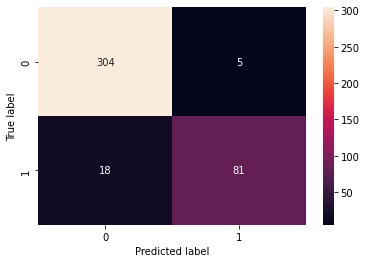

In [32]:
actual = predictions.select('label').toPandas()
predicted = predictions.select('prediction').toPandas()

print('Accuracy score of predicted data :',accuracy_score(actual, predicted))

# precision score
print('Precision Score of predicted data :',precision_score(actual, predicted))

# recall score
print('Recall Score of predicted data :',recall_score(actual, predicted))

# F1 score
print('F1 Score of predicted data :',f1_score(actual, predicted))

cf_matrix = confusion_matrix(actual, predicted)
sn.heatmap(cf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [33]:
print(len(lrModel.coefficients))

31


# Proposed Ways

In [34]:
print(df.groupBy(label_col).count().orderBy('count', ascending=False).toPandas())
print("\n")

  Churn Label  count
0          No   1097
1         Yes    304




In [35]:
print(df.groupBy("Online Security").count().orderBy('count', ascending=False).toPandas())
print("\n")

  Online Security  count
0              No    959
1             Yes    442




In [36]:
modified_df = df.withColumn("Online Security", f.when(df["Online Security"]=="No", "Yes").otherwise(df["Online Security"]))

In [37]:
print(modified_df.groupBy("Online Security").count().orderBy('count', ascending=False).toPandas())
print("\n")

  Online Security  count
0             Yes   1401




In [38]:
pipeline = Pipeline(stages = stages)
modified_df = pipelineModel.transform(modified_df)
selectedCols = ['label', 'features']
modified_df = modified_df.select(selectedCols)

In [39]:
predictions = lrModel.transform(modified_df)
predictions.show(10)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(31,[0,6,8,10,14,...|[13.7544338559184...|[0.99999893702068...|       0.0|
|  1.0|[0.0,1.0,1.0,1.0,...|[5.31581318807746...|[0.99511074060048...|       0.0|
|  0.0|[1.0,1.0,1.0,1.0,...|[17.2480430796753...|[0.99999996769497...|       0.0|
|  0.0|(31,[1,2,3,8,11,1...|[14.2594083592798...|[0.99999935846943...|       0.0|
|  0.0|(31,[1,2,3,9,15,1...|[5.14712184325440...|[0.99421751128413...|       0.0|
|  1.0|(31,[1,2,3,9,15,1...|[2.77003199381187...|[0.94103476184373...|       0.0|
|  0.0|(31,[0,2,3,9,15,1...|[9.79849985878562...|[0.99994446823686...|       0.0|
|  0.0|(31,[0,2,9,13,17,...|[7.32821611108937...|[0.99934368692843...|       0.0|
|  0.0|(31,[0,1,2,8,13,1...|[7.65154427359034...|[0.99952491625785...|       0.0|
|  1.0|(31,[0,1,

In [50]:
predictions.groupBy('prediction').count().orderBy('count', ascending=False).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1179|
|       1.0|  222|
+----------+-----+



In [51]:
predictions_modified = predictions.groupBy('prediction').count().orderBy('count', ascending=False).withColumn("prediction", f.when(predictions["prediction"] == 0, "No Churn").otherwise("Churn"))

# Insertion to DB

In [41]:
feature_importance_df.write.format('jdbc').options(
      url=f"jdbc:mysql://{HOST}/{DB_NAME}",
      driver='com.mysql.jdbc.Driver',
      dbtable='feature_importance',
      user=DB_USER,
      password=DB_PASS, 
      useSSL=False).mode('overwrite').save()

In [52]:
predictions_modified.write.format('jdbc').options(
      url=f"jdbc:mysql://{HOST}/{DB_NAME}",
      driver='com.mysql.jdbc.Driver',
      dbtable='prediction_modified',
      user=DB_USER,
      password=DB_PASS, 
      useSSL=False).mode('overwrite').save()